# **Deep Learning Group Project: Eye Disease Classification**
**Master's  Degree Program in Data Science and Advanced Analytics, with a specialization in Data Science (A.Y. 2022/2023)**<br/>
**NOVA IMS**<br/>


### **Group Information**

*   André Cunha, 20191224 - r20191224@novaims.unl.pt
*   Catarina Duarte, 20191211 - r20191211@novaims.unl.pt
*   Cláudia Rocha, 20191249 - r20191249@novaims.unl.pt
*   Dinis Melo, 20191190 - r20191190@novaims.unl.pt
*   Susana Dias, 20220198 - 20220198@novaims.unl.pt


### **Data Source** 

Kaggle dataset: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification

Link to the prepared dataset: https://drive.google.com/drive/folders/1HEti1Qv_-iXiOf2zp2amG8XFgk-HPuLj?usp=sharing

### **Main Steps** 


*  Run ResNet50, ResNet101, ResNet152, VGG16 and VGG19 with Transfer Learning
*  Compare the results with the handcrafted models and our best model from the previous notebooks
* Conclusion on the benefits of Transfer Learning





# **Import the Needed Libraries**

In [ ]:
!pip install -q -U keras-tuner

# Imports
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 
from keras.models import Model
from keras.layers import Dense, Conv2D
from tensorflow.keras import regularizers
import keras_tuner as kt
from tensorflow.keras.initializers import GlorotNormal
import keras



from sklearn.metrics import confusion_matrix

import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 4.0 MB/s eta 0:00:00


# **Needed Code**



We are repeating the same pre-processing steps from previous notebooks with the same seed to perserved the worked on data division. 

In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/Nova IMS/Projeto DL/"
main_folder, training_folder, testing_folder = "dataset_prepared/", "train/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'dataset_prepared.zip', 'dataset_prepared.zip')
    # Extract files
    zip_ = zipfile.ZipFile('dataset_prepared.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Mounted at /content/drive
File transfer completed in 10.526 seconds


In [ ]:
image_size=(128, 128)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

In [ ]:

# Generate an object of type tf.data.Dataset 
ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                labels='inferred',
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)
# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 3373 files belonging to 4 classes.
Using 2699 files for training.
Using 674 files for validation.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()

In [ ]:
ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 844 files belonging to 4 classes.


# **Functions**

We defined the functions used in the previous notebooks to compile the model and analize the results

In [ ]:
def compile_model(model, learning_rate = 0.001):
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                          ])

In [ ]:
def plot_training_history(history):
    df_hist = pd.DataFrame.from_dict(history.history)
    df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    # Plot loss curves
    ax1 = df_hist.plot(x="Epoch", y=['loss', 'val_loss'],
                       kind="line", grid=True, legend=True,
                       ylabel="Categorical cross-entropy", 
                       xlabel="Epoch", title="Loss curves",                  
                       color=['darkred', 'indianred'], alpha=0.75, fontsize=10, ax=axs[0])
    ax1.legend(loc=(0, -0.45), framealpha = 1.0)
    ax1.set_ylim([0, 1])

    # Plot accuracy curves
    ax2 = df_hist.plot(x="Epoch", y=['accuracy', 'val_accuracy'],
                       kind="line", grid=True, legend=True,
                       ylabel="Accuracy", 
                       xlabel="Epoch", title="Accuracy curves",                  
                       color=['darkblue', 'royalblue','green'], alpha=0.75, fontsize=10, ax=axs[1])
    ax2.legend(loc=(0, -0.45), framealpha=1.0)
    ax2.set_ylim([0, 1])

  

# **Data Preprocessing**


In [ ]:
preprocessing = Sequential([layers.Rescaling(1./255)], name="preprocessing")

In [ ]:
input_shape = tuple(batch_x_train.shape)


# **Transfer Learning**

Transfer learning is a popular technique that allows leveraging the knowledge gained while solving one problem to help solve another related problem. In transfer learning, a pre-trained model that was previously trained on a large dataset is used as a starting point for a new task, and then fine-tuned on a smaller dataset specific to the new task. 

This approach saves computational resources and time, as well as improves the performance of the new model, especially when the available data for the new task is limited. By leveraging transfer learning, deep learning models can be built faster and more accurately, which is particularly useful in applications such as object detection, sentiment analysis, and speech recognition, among others.

The transfer learning models we chose to perform were ResNet50, ResNet101, ResNet152, VGG16 and VGG19; that we had applied in the previous notebook. In the first step, we used the models with the fixed weights from the ImageNet dataset in ours with 20 epochs. The last step was to define 'trainable=True', unfreezing the basemodel and allowing it to learn our dataset in 10 epochs.


References: https://keras.io/guides/transfer_learning/#build-a-model




In [ ]:
pip install keras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.applications import  VGG16, VGG19, ResNet50, ResNet101, ResNet152, InceptionV3



## **1. ResNet50**

In [ ]:
base_model1 = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model1.trainable = False

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model1(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a categorical classification
outputs = keras.layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Fit the model
model.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
43/43 [==============================] - 37s 387ms/step - loss: 0.9360 - accuracy: 0.6073 - val_loss: 0.6527 - val_accuracy: 0.7478
Epoch 2/20
43/43 [==============================] - 17s 354ms/step - loss: 0.5953 - accuracy: 0.7644 - val_loss: 0.5690 - val_accuracy: 0.7908
Epoch 3/20
43/43 [==============================] - 19s 401ms/step - loss: 0.5334 - accuracy: 0.7992 - val_loss: 0.5343 - val_accuracy: 0.7967
Epoch 4/20
43/43 [==============================] - 17s 359ms/step - loss: 0.4671 - accuracy: 0.8292 - val_loss: 0.5239 - val_accuracy: 0.7967
Epoch 5/20
43/43 [==============================] - 17s 352ms/step - loss: 0.4404 - accuracy: 0.8370 - val_loss: 0.4744 - val_accuracy: 0.8160
Epoch 6/20
43/43 [==============================] - 17s 346ms/step - loss: 0.4017 - accuracy: 0.8577 - val_loss: 0.4551 - val_accuracy: 0.8205
Epoch 7/20
43/43 [==============================] - 17s 350ms/step - loss: 0.3896 - accuracy: 0.8518 - val_loss: 0.4986 - val_accuracy: 0.8042

### **Fine-tuning**



In [ ]:
# Unfreeze the base model
base_model1.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
            loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
Resnet50_transfer =model.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
43/43 [==============================] - 29s 441ms/step - loss: 0.2122 - accuracy: 0.9229 - val_loss: 0.3514 - val_accuracy: 0.8828
Epoch 2/10
43/43 [==============================] - 21s 431ms/step - loss: 0.1082 - accuracy: 0.9670 - val_loss: 0.3171 - val_accuracy: 0.8976
Epoch 3/10
43/43 [==============================] - 20s 416ms/step - loss: 0.0522 - accuracy: 0.9870 - val_loss: 0.3706 - val_accuracy: 0.8872
Epoch 4/10
43/43 [==============================] - 21s 444ms/step - loss: 0.0309 - accuracy: 0.9937 - val_loss: 0.3950 - val_accuracy: 0.9006
Epoch 5/10
43/43 [==============================] - 20s 416ms/step - loss: 0.0142 - accuracy: 0.9974 - val_loss: 0.4099 - val_accuracy: 0.9006
Epoch 6/10
43/43 [==============================] - 21s 447ms/step - loss: 0.0089 - accuracy: 0.9989 - val_loss: 0.3958 - val_accuracy: 0.8976
Epoch 7/10
43/43 [==============================] - 20s 414ms/step - loss: 0.0080 - accuracy: 0.9985 - val_loss: 0.4165 - val_accuracy: 0.8991

###**Plot Resnet50 transfer**

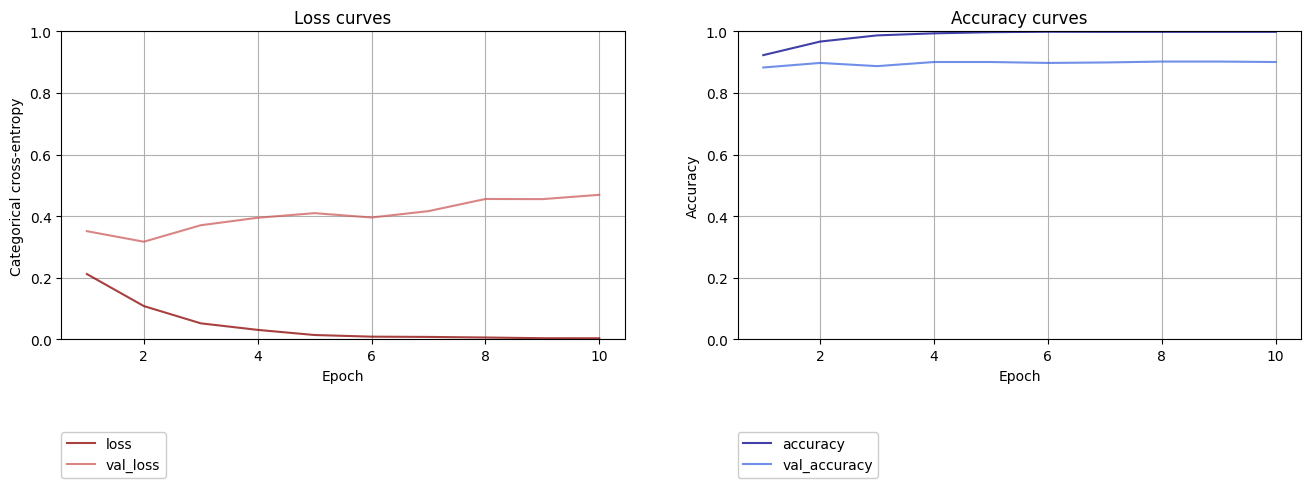

In [ ]:
plot_training_history(Resnet50_transfer)

## **1. ResNet101**

In [ ]:
base_model2 = keras.applications.ResNet101(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)

171446536/171446536 [==============================] - 1s 0us/step


In [ ]:
base_model2.trainable = False

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model2(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a categorical classification
outputs = keras.layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Fit the model
model.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
43/43 [==============================] - 26s 416ms/step - loss: 0.9277 - accuracy: 0.6250 - val_loss: 0.6539 - val_accuracy: 0.7404
Epoch 2/20
43/43 [==============================] - 18s 367ms/step - loss: 0.5725 - accuracy: 0.7777 - val_loss: 0.5466 - val_accuracy: 0.7938
Epoch 3/20
43/43 [==============================] - 17s 366ms/step - loss: 0.4972 - accuracy: 0.8044 - val_loss: 0.5196 - val_accuracy: 0.8027
Epoch 4/20
43/43 [==============================] - 19s 382ms/step - loss: 0.4478 - accuracy: 0.8307 - val_loss: 0.4694 - val_accuracy: 0.8160
Epoch 5/20
43/43 [==============================] - 17s 360ms/step - loss: 0.4067 - accuracy: 0.8507 - val_loss: 0.4542 - val_accuracy: 0.8175
Epoch 6/20
43/43 [==============================] - 17s 362ms/step - loss: 0.3816 - accuracy: 0.8566 - val_loss: 0.4380 - val_accuracy: 0.8412
Epoch 7/20
43/43 [==============================] - 18s 361ms/step - loss: 0.3535 - accuracy: 0.8711 - val_loss: 0.4733 - val_accuracy: 0.8071

### **Fine-tuning**



In [ ]:
# Unfreeze the base model
base_model2.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
            loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
Resnet101_transfer =model.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
43/43 [==============================] - 39s 555ms/step - loss: 0.2225 - accuracy: 0.9181 - val_loss: 0.3554 - val_accuracy: 0.8694
Epoch 2/10
43/43 [==============================] - 24s 521ms/step - loss: 0.0922 - accuracy: 0.9722 - val_loss: 0.3018 - val_accuracy: 0.9036
Epoch 3/10
43/43 [==============================] - 23s 484ms/step - loss: 0.0389 - accuracy: 0.9911 - val_loss: 0.3408 - val_accuracy: 0.8991
Epoch 4/10
43/43 [==============================] - 24s 479ms/step - loss: 0.0298 - accuracy: 0.9918 - val_loss: 0.4187 - val_accuracy: 0.9021
Epoch 5/10
43/43 [==============================] - 24s 511ms/step - loss: 0.0244 - accuracy: 0.9948 - val_loss: 0.4198 - val_accuracy: 0.8694
Epoch 6/10
43/43 [==============================] - 27s 576ms/step - loss: 0.0158 - accuracy: 0.9974 - val_loss: 0.3615 - val_accuracy: 0.9036
Epoch 7/10
43/43 [==============================] - 26s 559ms/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 0.3452 - val_accuracy: 0.9110

###**Plot Resnet101 transfer**

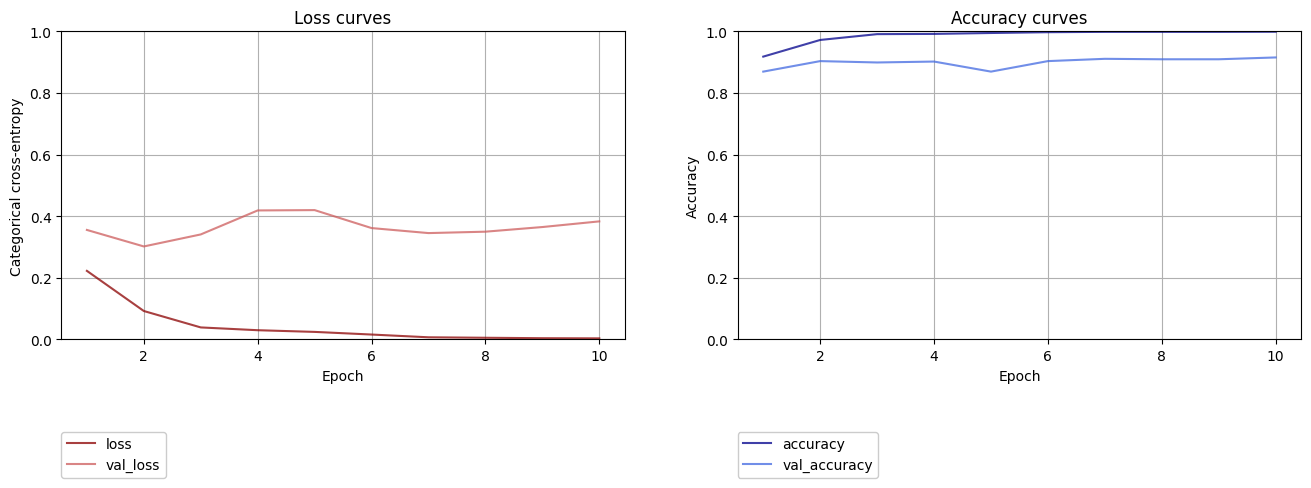

In [ ]:
plot_training_history(Resnet101_transfer)

## **1. ResNet152**

In [ ]:
base_model3 = keras.applications.ResNet152(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)

234698864/234698864 [==============================] - 4s 0us/step


In [ ]:
base_model3.trainable = False

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model3(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a categorical classification
outputs = keras.layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Fit the model
model.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
43/43 [==============================] - 30s 443ms/step - loss: 0.8968 - accuracy: 0.6265 - val_loss: 0.5900 - val_accuracy: 0.7715
Epoch 2/20
43/43 [==============================] - 20s 418ms/step - loss: 0.5658 - accuracy: 0.7795 - val_loss: 0.5282 - val_accuracy: 0.7953
Epoch 3/20
43/43 [==============================] - 19s 407ms/step - loss: 0.4891 - accuracy: 0.8088 - val_loss: 0.4915 - val_accuracy: 0.8101
Epoch 4/20
43/43 [==============================] - 18s 386ms/step - loss: 0.4516 - accuracy: 0.8203 - val_loss: 0.4604 - val_accuracy: 0.8071
Epoch 5/20
43/43 [==============================] - 21s 410ms/step - loss: 0.4027 - accuracy: 0.8451 - val_loss: 0.4244 - val_accuracy: 0.8249
Epoch 6/20
43/43 [==============================] - 19s 396ms/step - loss: 0.3778 - accuracy: 0.8588 - val_loss: 0.4111 - val_accuracy: 0.8323
Epoch 7/20
43/43 [==============================] - 20s 419ms/step - loss: 0.3665 - accuracy: 0.8599 - val_loss: 0.4159 - val_accuracy: 0.8309

### **Fine-tuning**



In [ ]:
# Unfreeze the base model
base_model3.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
            loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
Resnet152_transfer =model.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
43/43 [==============================] - 50s 694ms/step - loss: 0.2415 - accuracy: 0.9018 - val_loss: 0.3131 - val_accuracy: 0.8828
Epoch 2/10
43/43 [==============================] - 28s 616ms/step - loss: 0.1042 - accuracy: 0.9644 - val_loss: 0.2837 - val_accuracy: 0.9095
Epoch 3/10
43/43 [==============================] - 28s 612ms/step - loss: 0.0485 - accuracy: 0.9867 - val_loss: 0.3100 - val_accuracy: 0.9021
Epoch 4/10
43/43 [==============================] - 29s 627ms/step - loss: 0.0237 - accuracy: 0.9937 - val_loss: 0.3349 - val_accuracy: 0.9021
Epoch 5/10
43/43 [==============================] - 28s 613ms/step - loss: 0.0130 - accuracy: 0.9985 - val_loss: 0.3775 - val_accuracy: 0.9021
Epoch 6/10
43/43 [==============================] - 29s 617ms/step - loss: 0.0080 - accuracy: 0.9985 - val_loss: 0.3777 - val_accuracy: 0.9110
Epoch 7/10
43/43 [==============================] - 29s 609ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.3952 - val_accuracy: 0.9095

###**Plot Resnet152 transfer**

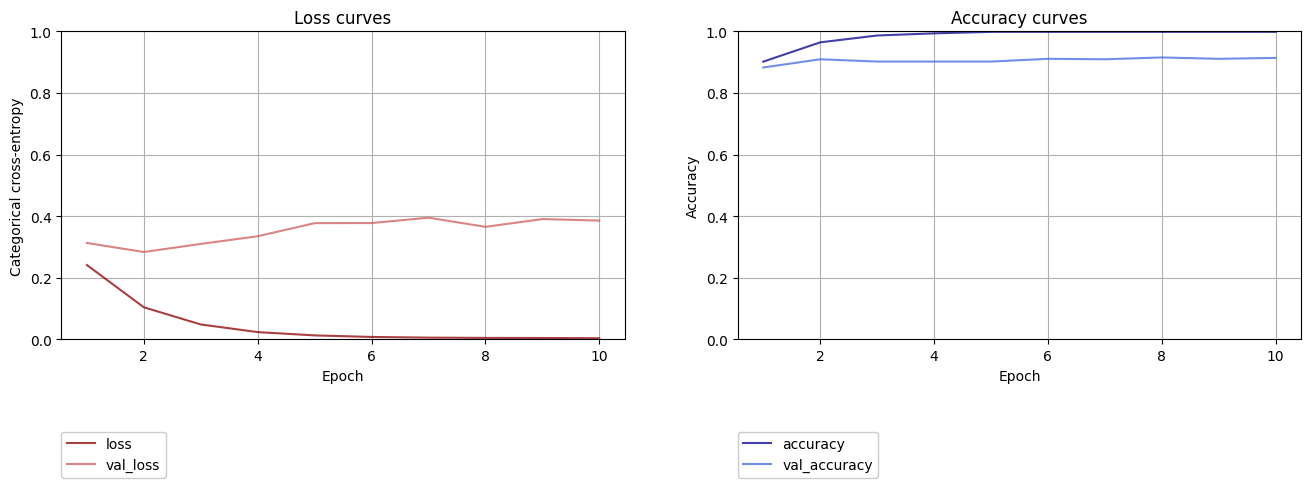

In [ ]:
plot_training_history(Resnet152_transfer)

## **2. VGG16**

In [ ]:
base_model4 = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model4.trainable = False

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model4(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Fit
model.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
43/43 [==============================] - 23s 418ms/step - loss: 2.5261 - accuracy: 0.4450 - val_loss: 1.5138 - val_accuracy: 0.5786
Epoch 2/20
43/43 [==============================] - 18s 351ms/step - loss: 1.2990 - accuracy: 0.6206 - val_loss: 1.0116 - val_accuracy: 0.6662
Epoch 3/20
43/43 [==============================] - 17s 353ms/step - loss: 0.9582 - accuracy: 0.6840 - val_loss: 0.8379 - val_accuracy: 0.7151
Epoch 4/20
43/43 [==============================] - 17s 356ms/step - loss: 0.7901 - accuracy: 0.7243 - val_loss: 0.7716 - val_accuracy: 0.7136
Epoch 5/20
43/43 [==============================] - 18s 365ms/step - loss: 0.6888 - accuracy: 0.7443 - val_loss: 0.6867 - val_accuracy: 0.7537
Epoch 6/20
43/43 [==============================] - 17s 354ms/step - loss: 0.6292 - accuracy: 0.7625 - val_loss: 0.7056 - val_accuracy: 0.7567
Epoch 7/20
43/43 [==============================] - 17s 356ms/step - loss: 0.5771 - accuracy: 0.7818 - val_loss: 0.6175 - val_accuracy: 0.7685

### **Fine tuning**

In [ ]:
# Unfreeze the base model
base_model4.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
            loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
VGG16_transfer=model.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
43/43 [==============================] - 30s 478ms/step - loss: 0.4162 - accuracy: 0.8351 - val_loss: 0.4061 - val_accuracy: 0.8472
Epoch 2/10
43/43 [==============================] - 21s 449ms/step - loss: 0.2031 - accuracy: 0.9255 - val_loss: 0.3993 - val_accuracy: 0.8591
Epoch 3/10
43/43 [==============================] - 22s 470ms/step - loss: 0.1205 - accuracy: 0.9615 - val_loss: 0.3711 - val_accuracy: 0.8813
Epoch 4/10
43/43 [==============================] - 22s 463ms/step - loss: 0.0645 - accuracy: 0.9830 - val_loss: 0.3862 - val_accuracy: 0.8872
Epoch 5/10
43/43 [==============================] - 21s 438ms/step - loss: 0.0511 - accuracy: 0.9896 - val_loss: 0.3959 - val_accuracy: 0.8917
Epoch 6/10
43/43 [==============================] - 22s 472ms/step - loss: 0.0319 - accuracy: 0.9952 - val_loss: 0.4040 - val_accuracy: 0.8828
Epoch 7/10
43/43 [==============================] - 21s 434ms/step - loss: 0.0272 - accuracy: 0.9967 - val_loss: 0.4600 - val_accuracy: 0.8976

###**Plot VGG16 transfer**

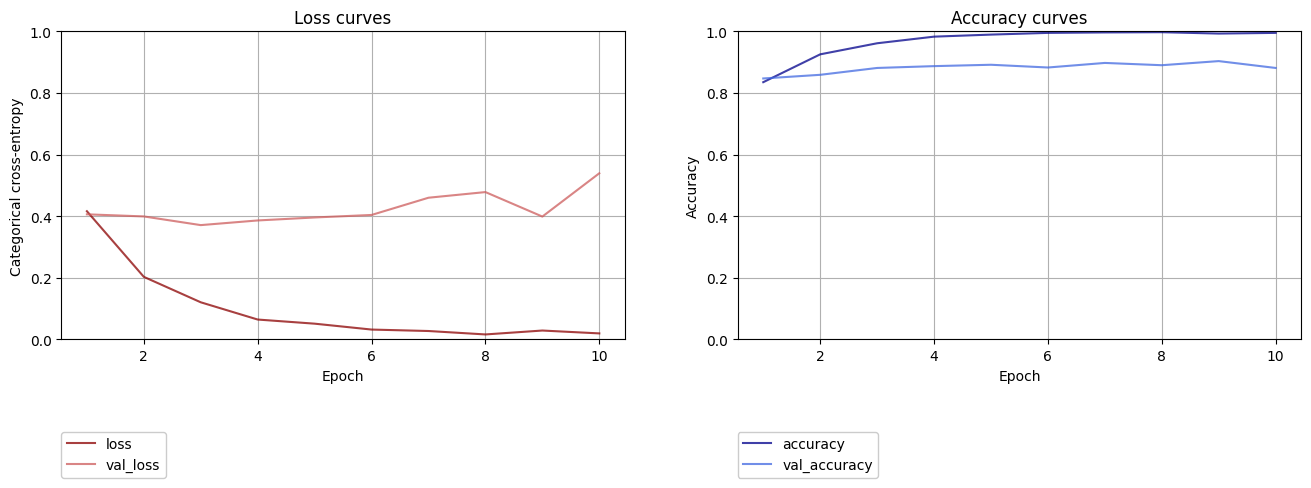

In [ ]:
plot_training_history(VGG16_transfer)

## **2. VGG19**

In [ ]:
base_model5 = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
base_model5.trainable = False

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model5(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Fit
model.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
43/43 [==============================] - 18s 364ms/step - loss: 2.6611 - accuracy: 0.4109 - val_loss: 1.6692 - val_accuracy: 0.5608
Epoch 2/20
43/43 [==============================] - 17s 360ms/step - loss: 1.2970 - accuracy: 0.5928 - val_loss: 1.2115 - val_accuracy: 0.6365
Epoch 3/20
43/43 [==============================] - 19s 392ms/step - loss: 1.0180 - accuracy: 0.6499 - val_loss: 0.9638 - val_accuracy: 0.6855
Epoch 4/20
43/43 [==============================] - 20s 408ms/step - loss: 0.8574 - accuracy: 0.6884 - val_loss: 0.8615 - val_accuracy: 0.7196
Epoch 5/20
43/43 [==============================] - 17s 356ms/step - loss: 0.7587 - accuracy: 0.7180 - val_loss: 0.7821 - val_accuracy: 0.7374
Epoch 6/20
43/43 [==============================] - 19s 393ms/step - loss: 0.6945 - accuracy: 0.7303 - val_loss: 0.7286 - val_accuracy: 0.7537
Epoch 7/20
43/43 [==============================] - 17s 350ms/step - loss: 0.6397 - accuracy: 0.7525 - val_loss: 0.7004 - val_accuracy: 0.7611

### **Fine tuning**

In [ ]:
# Unfreeze the base model
base_model5.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
            loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
VGG19_transfer=model.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
43/43 [==============================] - 23s 446ms/step - loss: 0.4061 - accuracy: 0.8396 - val_loss: 0.4311 - val_accuracy: 0.8323
Epoch 2/10
43/43 [==============================] - 23s 489ms/step - loss: 0.2146 - accuracy: 0.9200 - val_loss: 0.4148 - val_accuracy: 0.8501
Epoch 3/10
43/43 [==============================] - 24s 485ms/step - loss: 0.1256 - accuracy: 0.9570 - val_loss: 0.4395 - val_accuracy: 0.8576
Epoch 4/10
43/43 [==============================] - 23s 489ms/step - loss: 0.0758 - accuracy: 0.9815 - val_loss: 0.4637 - val_accuracy: 0.8576
Epoch 5/10
43/43 [==============================] - 21s 454ms/step - loss: 0.0506 - accuracy: 0.9881 - val_loss: 0.4487 - val_accuracy: 0.8620
Epoch 6/10
43/43 [==============================] - 22s 475ms/step - loss: 0.0326 - accuracy: 0.9959 - val_loss: 0.4432 - val_accuracy: 0.8650
Epoch 7/10
43/43 [==============================] - 21s 454ms/step - loss: 0.0217 - accuracy: 0.9967 - val_loss: 0.4683 - val_accuracy: 0.8739

###**Plot VGG19 transfer**

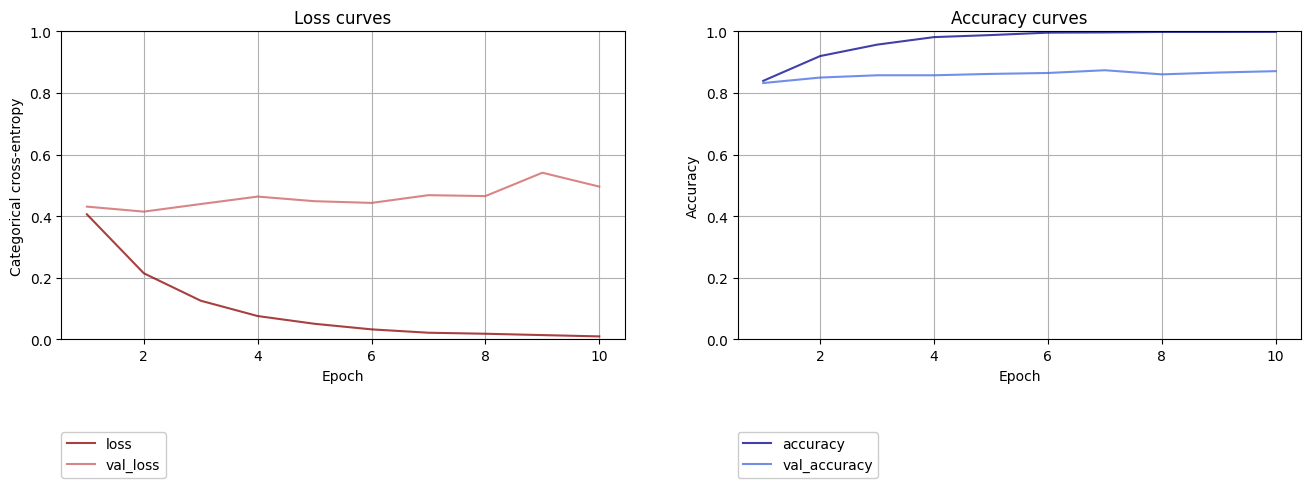

In [ ]:
plot_training_history(VGG19_transfer)

# **Results Comparison**

Model Name          |  Accuracy  | Validation Accuracy| Loss   | Validation Loss
--------------------|------------|--------------------|--------|----------------
Model V1 (best)  | 0.8418       | 0.8353               | 0.4067 | 0.4460
ResNet50 Handcrafted| 0.2479     | 0.2404             | 1.3867 | 1.3886
ResNet50 TR         | 0.9985     | 0.9006             | 0.0037 | 0.4694
ResNet101 TR        | 0.9989     | 0.9154             | 0.0034 | 0.3832
ResNet152 TR        | 0.9985     | 0.9139             | 0.0038 | 0.3858
VGG12 Handcrafted   | 0.8881     | 0.8234             | 0.2956 | 0.4379
VGG16 TR            | 0.9952     | 0.8813             | 0.0195 | 0.5394
VGG19 TR            | 0.9985     | 0.8709             | 0.0098 | 0.4961



Based on the previous results, we can observe that the transfer learning (TL) models (``ResNet50``,``ResNet101`` and ``ResNet152``) are much more effective in comparison to the handcrafted model from the previous notebooks (``ResNet50``). In the ResNet models, it is evident how much the **performance** can be **improved** through the previous knowledge of these TL models, with much higher values of accuracy and validation accuracy. On the other hand, the loss and validation loss values are also significantly low. When comparing the TL, we can see that **performance also increases along with the depth** of these models.

Regarding the VGG models, the **discrepancy** between the handcrafted model (``VGG12``) and the transfer learning models (``VGG16`` and ``VGG19``) are **lower** in comparison to ResNet, while also having a higher accuracy and lower loss. However, these models are more prone to **overfitting**. Contrarily to ResNet, the validation accuracy of these models did not increase along with the depth of the model(from ``VGG16`` to ``VGG19``).

In comparison to our best hancrafted model, ``Model V1``, all of the **TL models outperform** it in terms of accuracy of training and validation. The values of validation loss of ``Model V1`` are similar to the rest of the models.

Finally, we also noticed that the model had good performance in predicting our dataset without the fine-tuning and that, compared to all the models in the previous notebooks, the the running time was much lower.